In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
train_data = datasets.MNIST(root = 'data',train=True,transform=ToTensor(),download=True)
test_data = datasets.MNIST(root = 'data',train=False,transform=ToTensor(),download=True)

In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [6]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [7]:
from torch.utils.data import DataLoader

loaders = {
    'train': DataLoader(train_data,batch_size = 100, shuffle = True, num_workers = 1),
    'test': DataLoader(test_data,batch_size = 100, shuffle = True, num_workers = 1)
}

In [8]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1ca5bb6b490>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1ca5b5b5110>}

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x),2))
        x = F.relu(F.max_pool2d(self.conv2_dropout(self.conv2(x)),2))
        x = x.view(-1,320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x,training=self.training)
        x = self.fc2(x)
        return F.softmax(x)

In [10]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
model = CNN().to(device)

lr = 0.001

optimizer = optim.Adam(model.parameters(),lr=lr)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx , (feature , label) in enumerate(loaders['train']):
        feature , label = feature.to(device) , label.to(device)
        optimizer.zero_grad()
        output = model(feature)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(f'Train Epoch {epoch} [{batch_idx * len(feature)} / {len(loaders["train"].dataset)} ({100. * batch_idx / len(loaders["train"]):.0f}%)]\t{loss.item():.6f}')

def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for feature , label in loaders['test']:
            feature , label = feature.to(device) , label.to(device)
            output = model(feature)
            test_loss += loss_fn(output, label).item()
            pred = output.argmax(dim = 1, keepdim = True)
            correct += pred.eq(label.view_as(pred)).sum().item()

    test_loss /= len(loaders['test'].dataset)
    print(f'\nTest set average loss: {test_loss:.4f}, Accuracy {correct}/{len(loaders["test"].dataset)} ({100. * correct / len(loaders["test"].dataset):.0f}%\n)')

In [12]:
n_epochs = 10

for epoch in range(1,n_epochs+1):
    train(epoch)
    test()

C:\Users\M.HEPTON\AppData\Local\Temp\ipykernel_16148\3872845326.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train Epoch 1 [0 / 60000 (0%)]	2.304220
Train Epoch 1 [2000 / 60000 (3%)]	2.294413
Train Epoch 1 [4000 / 60000 (7%)]	2.217700
Train Epoch 1 [6000 / 60000 (10%)]	2.031402
Train Epoch 1 [8000 / 60000 (13%)]	1.981275
Train Epoch 1 [10000 / 60000 (17%)]	1.906870
Train Epoch 1 [12000 / 60000 (20%)]	1.917311
Train Epoch 1 [14000 / 60000 (23%)]	1.844629
Train Epoch 1 [16000 / 60000 (27%)]	1.755119
Train Epoch 1 [18000 / 60000 (30%)]	1.769073
Train Epoch 1 [20000 / 60000 (33%)]	1.740011
Train Epoch 1 [22000 / 60000 (37%)]	1.757593
Train Epoch 1 [24000 / 60000 (40%)]	1.697444
Train Epoch 1 [26000 / 60000 (43%)]	1.719391
Train Epoch 1 [28000 / 60000 (47%)]	1.707078
Train Epoch 1 [30000 / 60000 (50%)]	1.720793
Train Epoch 1 [32000 / 60000 (53%)]	1.708080
Train Epoch 1 [34000 / 60000 (57%)]	1.681798
Train Epoch 1 [36000 / 60000 (60%)]	1.704705
Train Epoch 1 [38000 / 60000 (63%)]	1.645497
Train Epoch 1 [40000 / 60000 (67%)]	1.710940
Train Epoch 1 [42000 / 60000 (70%)]	1.676385
Train Epoch 1 [44000 

Prediction: 2 
Label: 2


C:\Users\M.HEPTON\AppData\Local\Temp\ipykernel_16148\3872845326.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


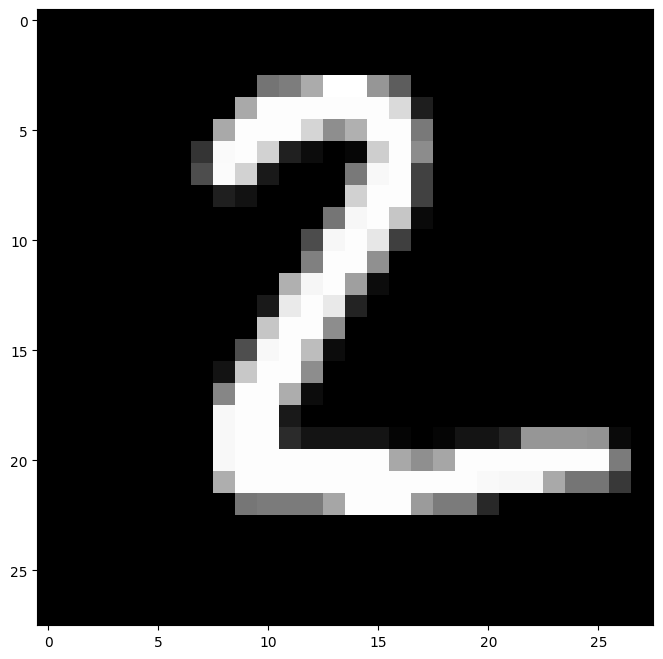

Prediction: 1 
Label: 1


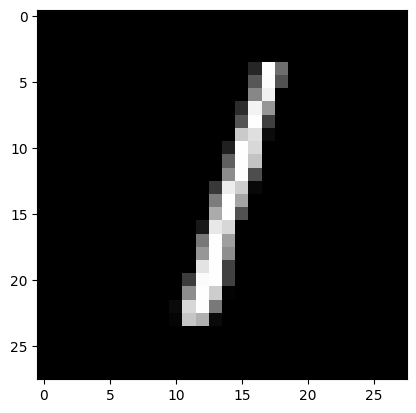

Prediction: 0 
Label: 0


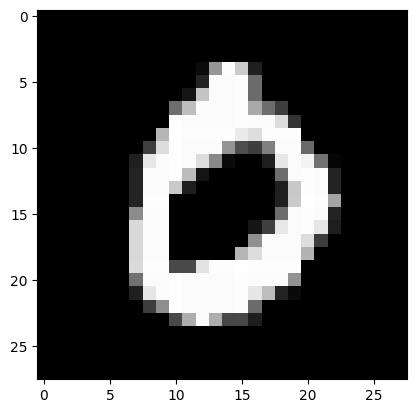

Prediction: 4 
Label: 4


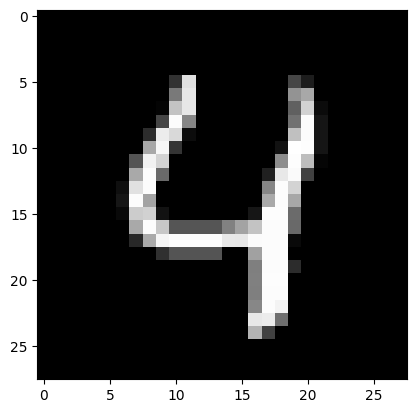

Prediction: 1 
Label: 1


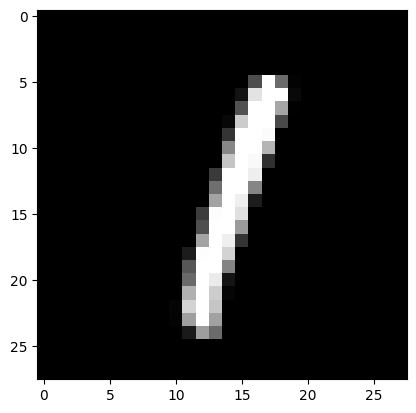

Prediction: 4 
Label: 4


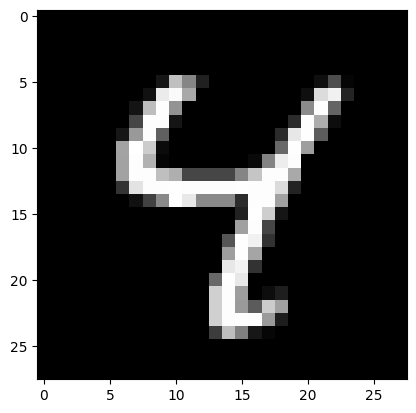

Prediction: 9 
Label: 9


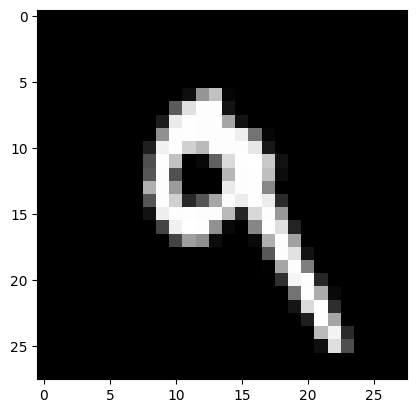

Prediction: 5 
Label: 5


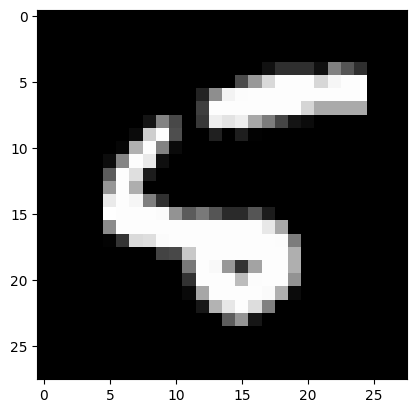

Prediction: 9 
Label: 9


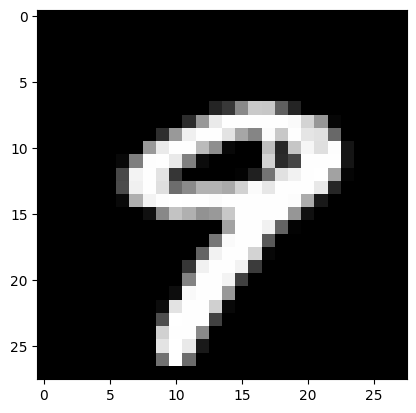

Prediction: 0 
Label: 0


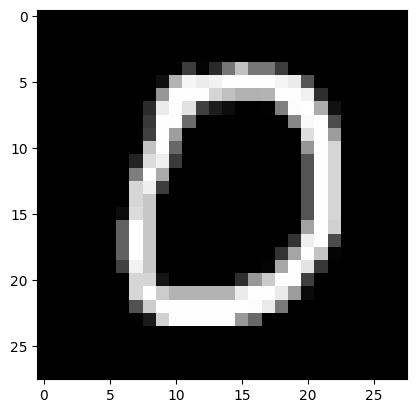

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))

for i in range(1,11):
    model.eval()

    feature , label = test_data[i]
    
    feature = feature.unsqueeze(0).to(device)
    
    output = model(feature)
    
    prediction = output.argmax(dim=1 , keepdim = True).item()
    
    print(f"Prediction: {prediction}", f"\nLabel: {label}")
    
    image = feature.squeeze(0).squeeze(0).cpu().numpy()

    plt.imshow(image, cmap = 'grey')
    plt.show()